Follows YouTube Tutorial at <https://www.youtube.com/watch?v=GIsg-ZUy0MY> at timestamp 1:33:00

We'll be using linear regression for the problem of image classification. We will use torch and torch vision. `torchvision` contains utility for working with images in PyTorch. It also contains helper classes to download and import popular datasets like MNIST automatically.

In [1]:
import torch
import torchvision
from torchvision.datasets import MNIST
import numpy as np

In [2]:
dataset = MNIST(root='data/', download=True)

d:\Projects\machine-learning\venv\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Downloads the images to the `data/` directory and creates a PyTorch dataset. On subsequent executions, the download is skipped as the data is already downloaded.

In [3]:
len(dataset)

60000

There are extra 10,000 images for testing

In [4]:
test_dataset = MNIST(root='data/', train=False)

In [5]:
dataset[0]

(<PIL.Image.Image image mode=L size=28x28 at 0x1C88BFA4DC0>, 5)

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

Label: 5


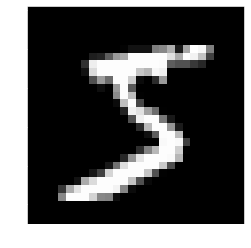

In [7]:
index = 0
image, label = dataset[index]
plt.imshow(image, cmap='gray')
print(f'Label: {label}')

Label: 3


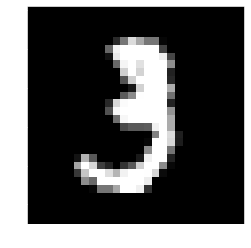

In [8]:
index = 10
image, label = dataset[index]
plt.imshow(image, cmap='gray')
print(f'Label: {label}')

We need to transform the images to tensors, otherwise PyTorch can't work with them.  
We can do this by specifying a transform while creating the dataset.

In [9]:
import torchvision.transforms as transforms

PyTorch datasets allow us to specify one or more transformation functions that are applied to the images as they are loaded. The `torchvision.transforms` module contains many such predefined functions. We'll use the `ToTensor` transform to convert images into PyTorch tensors.

In [10]:
dataset = MNIST(root='data/', train=True, transform=transforms.ToTensor())

In [11]:
img_tensor, label = dataset[0]
img_tensor.shape, label

(torch.Size([1, 28, 28]), 5)

The image is now converted to a 1x28x28 tensor. The first dimension tracks color channels. The second and third dimensions represent pixels along the height and width of the image, respectively. Since images in the MNIST dataset are grayscale, there's just one channel. Other datasets have images with color, in which case there are three channels: red, green, and blue (RGB). 

Let's look at some sample values inside the tensor.

In [12]:
print(img_tensor[:, 10:15, 10:15])
print(torch.max(img_tensor), torch.min(img_tensor))

tensor([[[0.0039, 0.6039, 0.9922, 0.3529, 0.0000],
         [0.0000, 0.5451, 0.9922, 0.7451, 0.0078],
         [0.0000, 0.0431, 0.7451, 0.9922, 0.2745],
         [0.0000, 0.0000, 0.1373, 0.9451, 0.8824],
         [0.0000, 0.0000, 0.0000, 0.3176, 0.9412]]])
tensor(1.) tensor(0.)


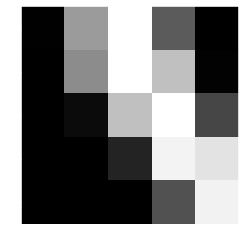

In [13]:
plt.imshow(img_tensor[0, 10:15, 10:15].numpy(), cmap='gray')

## Training and Validation Datasets

While building real-world machine learning models, it is quite common to split the dataset into three parts:

1. **Training set** - used to train the model, i.e., compute the loss and adjust the model's weights using gradient descent.
2. **Validation set** - used to evaluate the model during training, adjust hyperparameters (learning rate, etc.), and pick the best version of the model.
3. **Test set** - used to compare different models or approaches and report the model's final accuracy.

In the MNIST dataset, there are 60,000 training images and 10,000 test images. The test set is standardized so that different researchers can report their models' results against the same collection of images. 

Since there's no predefined validation set, we must manually split the 60,000 images into training and validation datasets. Let's set aside 10,000 randomly chosen images for validation. We can do this using the `random_spilt` method from PyTorch.

In [14]:
from torch.utils.data import random_split

train_ds, val_ds = random_split(dataset, [50000, 10000])
len(train_ds), len(val_ds)

(50000, 10000)

It's essential to choose a random sample for creating a validation set. Training data is often sorted by the target labels, i.e., images of 0s, followed by 1s, followed by 2s, etc. If we create a validation set using the last 20% of images, it would only consist of 8s and 9s. In contrast, the training set would contain no 8s or 9s. Such a training-validation would make it impossible to train a useful model.

We can now create data loaders to help us load the data in batches. We'll use a batch size of 128.

In [15]:
from torch.utils.data import DataLoader

batch_size = 128
train_dl = DataLoader(dataset=train_ds, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(dataset=val_ds, batch_size=batch_size)

## Model

Now that we have prepared our data loaders, we can define our model.

* A **logistic regression** model is almost identical to a linear regression model. It contains weights and bias matrices, and the output is obtained using simple matrix operations (`pred = x @ w.t() + b`). 

* As we did with linear regression, we can use `nn.Linear` to create the model instead of manually creating and initializing the matrices.

* Since `nn.Linear` expects each training example to be a vector, each `1x28x28` image tensor is _flattened_ into a vector of size 784 `(28*28)` before being passed into the model. 

* The output for each image is a vector of size 10, with each element signifying the probability of a particular target label (i.e., 0 to 9). The predicted label for an image is simply the one with the highest probability.

In [16]:
import torch.nn as nn

input_size = 28*28
num_classes = 10

model = nn.Linear(input_size, num_classes)

In [17]:
print(model.weight.shape)

torch.Size([10, 784])


In [18]:
print(model.bias.shape)

torch.Size([10])


In [19]:
for images, labels in train_dl:
    print(labels)
    print(images.shape)
    outputs = model(images)
    print(outputs)
    break

tensor([6, 2, 5, 6, 2, 6, 6, 4, 5, 8, 7, 1, 2, 7, 9, 2, 4, 0, 8, 5, 6, 5, 0, 9,
        7, 3, 8, 0, 3, 2, 4, 4, 8, 6, 5, 4, 0, 0, 2, 4, 6, 0, 7, 4, 6, 1, 2, 7,
        0, 6, 1, 7, 5, 0, 8, 4, 6, 0, 2, 3, 7, 3, 4, 9, 4, 4, 0, 8, 9, 1, 0, 1,
        5, 0, 4, 8, 1, 3, 0, 5, 9, 9, 4, 4, 1, 2, 3, 8, 0, 0, 9, 3, 2, 0, 3, 3,
        2, 1, 2, 9, 7, 5, 0, 9, 3, 1, 0, 5, 8, 3, 4, 1, 1, 1, 5, 9, 0, 3, 2, 9,
        2, 2, 1, 4, 1, 0, 4, 4])
torch.Size([128, 1, 28, 28])


RuntimeError: mat1 and mat2 shapes cannot be multiplied (3584x28 and 784x10)

The code above leads to an error because our input data does not have the right shape. Our images are of the shape 1x28x28, but we need them to be vectors of size 784, i.e., we need to flatten them. We'll use the `.reshape` method of a tensor, which will allow us to efficiently 'view' each image as a flat vector without really creating a copy of the underlying data. To include this additional functionality within our model, we need to define a custom model by extending the `nn.Module` class from PyTorch. 

A class in Python provides a "blueprint" for creating objects. Let's look at an example of defining a new class in Python.

In [20]:
images.shape

torch.Size([128, 1, 28, 28])

In [21]:
images.reshape(128, 28*28)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [22]:
class MnistModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)

    def forward(self, xb):
        xb = xb.reshape(-1, 784)
        out = self.linear(xb)
        return out

model = MnistModel()

`xb.reshape(-1, 28*28)` indicates to PyTorch that we want a *view* of the `xb` tensor with two dimensions. The length along the 2nd dimension is 28\*28 (i.e., 784). One argument to `.reshape` can be set to `-1` (in this case, the first dimension) to let PyTorch figure it out automatically based on the shape of the original tensor.

Note that the model no longer has `.weight` and `.bias` attributes (as they are now inside the `.linear` attribute), but it does have a `.parameters` method that returns a list containing the weights and bias.

In [23]:
model.linear.weight, model.linear.bias

(Parameter containing:
 tensor([[ 0.0247,  0.0166,  0.0050,  ..., -0.0215, -0.0352,  0.0080],
         [-0.0167, -0.0100,  0.0269,  ..., -0.0102,  0.0243, -0.0002],
         [ 0.0218, -0.0316,  0.0021,  ...,  0.0012, -0.0129, -0.0091],
         ...,
         [-0.0283,  0.0134, -0.0249,  ..., -0.0188, -0.0232, -0.0346],
         [-0.0283, -0.0160,  0.0197,  ...,  0.0104, -0.0229, -0.0244],
         [-0.0276, -0.0239, -0.0113,  ..., -0.0169, -0.0259,  0.0232]],
        requires_grad=True),
 Parameter containing:
 tensor([-0.0092,  0.0252,  0.0217,  0.0077,  0.0064, -0.0271,  0.0158,  0.0356,
         -0.0107, -0.0264], requires_grad=True))

In [24]:
list(model.parameters())

[Parameter containing:
 tensor([[ 0.0247,  0.0166,  0.0050,  ..., -0.0215, -0.0352,  0.0080],
         [-0.0167, -0.0100,  0.0269,  ..., -0.0102,  0.0243, -0.0002],
         [ 0.0218, -0.0316,  0.0021,  ...,  0.0012, -0.0129, -0.0091],
         ...,
         [-0.0283,  0.0134, -0.0249,  ..., -0.0188, -0.0232, -0.0346],
         [-0.0283, -0.0160,  0.0197,  ...,  0.0104, -0.0229, -0.0244],
         [-0.0276, -0.0239, -0.0113,  ..., -0.0169, -0.0259,  0.0232]],
        requires_grad=True),
 Parameter containing:
 tensor([-0.0092,  0.0252,  0.0217,  0.0077,  0.0064, -0.0271,  0.0158,  0.0356,
         -0.0107, -0.0264], requires_grad=True)]

In [25]:
for images, labels in train_dl:
    outputs = model(images)
    break

outputs.shape, outputs[:2].data

(torch.Size([128, 10]),
 tensor([[-0.0547, -0.0134, -0.0419,  0.1515,  0.1109, -0.1277,  0.2058,  0.2180,
           0.1932, -0.1039],
         [-0.4370, -0.1695, -0.1081, -0.2481,  0.2956,  0.3238,  0.3282,  0.2125,
          -0.3831,  0.2230]]))

For each of the 100 input images, we get 10 outputs, one for each class. As discussed earlier, we'd like these outputs to represent probabilities. Each output row's elements must lie between 0 to 1 and add up to 1, which is not the case. 

To convert the output rows into probabilities, we use the softmax function, which has the following formula:

![softmax](https://i.imgur.com/EAh9jLN.png)

Then, we divide them by their sum to ensure that they add up to 1. The resulting vector can thus be interpreted as probabilities.

While it's easy to implement the softmax function (you should try it!), we'll use the implementation that's provided within PyTorch because it works well with multidimensional tensors (a list of output rows in our case).

In [26]:
import torch.nn.functional as F

In [27]:
probs = F.softmax(outputs, dim=1)

print(f'Sample probabilities: {probs[:2].data}')

print(f"Sum: {torch.sum(probs[0]).item()}")

Sample probabilities: tensor([[0.0890, 0.0927, 0.0901, 0.1094, 0.1050, 0.0827, 0.1155, 0.1169, 0.1140,
         0.0847],
        [0.0618, 0.0808, 0.0859, 0.0747, 0.1286, 0.1323, 0.1329, 0.1183, 0.0652,
         0.1196]])
Sum: 1.0


Finally, we can determine the predicted label for each image by simply choosing the index of the element with the highest probability in each output row. We can do this using `torch.max`, which returns each row's largest element and the corresponding index.

In [28]:
max_probs, preds = torch.max(probs, dim=1)

preds, labels

(tensor([7, 6, 6, 0, 4, 5, 7, 5, 7, 6, 6, 7, 8, 9, 6, 7, 7, 7, 7, 5, 7, 9, 7, 2,
         9, 7, 6, 2, 2, 6, 7, 1, 7, 8, 6, 9, 7, 7, 9, 7, 9, 3, 7, 7, 7, 1, 7, 7,
         7, 9, 6, 9, 7, 7, 6, 7, 7, 6, 7, 6, 7, 7, 7, 6, 0, 6, 9, 3, 7, 9, 6, 6,
         6, 3, 7, 6, 4, 6, 8, 6, 7, 6, 7, 1, 7, 0, 7, 6, 6, 2, 4, 6, 6, 9, 6, 4,
         5, 7, 5, 7, 7, 6, 7, 6, 6, 4, 6, 7, 7, 7, 6, 8, 5, 7, 7, 7, 7, 6, 4, 6,
         7, 6, 6, 4, 7, 2, 6, 7]),
 tensor([9, 0, 3, 1, 7, 7, 2, 4, 9, 0, 3, 8, 7, 1, 0, 7, 4, 5, 3, 8, 9, 1, 4, 7,
         1, 5, 8, 7, 6, 3, 6, 0, 8, 6, 3, 1, 6, 8, 7, 3, 1, 7, 9, 6, 3, 6, 4, 7,
         3, 7, 6, 1, 4, 7, 1, 2, 4, 0, 0, 8, 8, 9, 2, 0, 1, 5, 1, 7, 8, 1, 0, 8,
         2, 6, 9, 2, 8, 6, 7, 0, 3, 5, 9, 0, 4, 1, 6, 6, 8, 7, 2, 3, 5, 1, 0, 5,
         3, 8, 7, 9, 9, 6, 3, 3, 6, 7, 6, 7, 8, 3, 0, 6, 7, 0, 3, 8, 6, 7, 5, 9,
         8, 8, 2, 6, 5, 7, 6, 0]))

Most of the predicted labels are different from the actual labels. That's because we have started with randomly initialized weights and biases. We need to train the model, i.e., adjust the weights using gradient descent to make better predictions.

## Evaluation Metric and Loss Function

Just as with linear regression, we need a way to evaluate how well our model is performing. A natural way to do this would be to find the percentage of labels that were predicted correctly, i.e,. the **accuracy** of the predictions. 

In [29]:
def accuracy(preds, labels):
    return torch.sum(preds == labels).item() / len(preds)

The `==` operator performs an element-wise comparison of two tensors with the same shape and returns a tensor of the same shape, containing `True` for unequal elements and `False` for equal elements. Passing the result to `torch.sum` returns the number of labels that were predicted correctly. Finally, we divide by the total number of images to get the accuracy. 

Note that we don't need to apply softmax to the outputs since its results have the same relative order. This is because `e^x` is an increasing function, i.e., if `y1 > y2`, then `e^y1 > e^y2`. The same holds after averaging out the values to get the softmax.

Let's calculate the accuracy of the current model on the first batch of data. 

In [30]:
accuracy(preds, labels)

0.0859375

Accuracy is an excellent way for us (humans) to evaluate the model. However, we can't use it as a loss function for optimizing our model using gradient descent for the following reasons:

1. It's not a differentiable function. `torch.max` and `==` are both non-continuous and non-differentiable operations, so we can't use the accuracy for computing gradients w.r.t the weights and biases.

2. It doesn't take into account the actual probabilities predicted by the model, so it can't provide sufficient feedback for incremental improvements. 

For these reasons, accuracy is often used as an **evaluation metric** for classification, but not as a loss function. A commonly used loss function for classification problems is the **cross-entropy**, which has the following formula:

$$
D(\hat{y}, y) = - \sum_{j}{y_j ln \hat{y_j}}
$$

While it looks complicated, it's actually quite simple:

* For each output row, pick the predicted probability for the correct label. E.g., if the predicted probabilities for an image are `[0.1, 0.3, 0.2, ...]` and the correct label is `1`, we pick the corresponding element `0.3` and ignore the rest.

* Then, take the [logarithm](https://en.wikipedia.org/wiki/Logarithm) of the picked probability. If the probability is high, i.e., close to 1, then its logarithm is a very small negative value, close to 0. And if the probability is low (close to 0), then the logarithm is a very large negative value. We also multiply the result by -1, which results is a large postive value of the loss for poor predictions.

![](https://www.intmath.com/blog/wp-content/images/2019/05/log10.png)

* Finally, take the average of the cross entropy across all the output rows to get the overall loss for a batch of data.

Unlike accuracy, cross-entropy is a continuous and differentiable function. It also provides useful feedback for incremental improvements in the model (a slightly higher probability for the correct label leads to a lower loss). These two factors make cross-entropy a better choice for the loss function.

As you might expect, PyTorch provides an efficient and tensor-friendly implementation of cross-entropy as part of the `torch.nn.functional` package. Moreover, it also performs softmax internally, so we can directly pass in the model's outputs without converting them into probabilities.

In [31]:
loss_fn = F.cross_entropy

In [32]:
loss = loss_fn(outputs, labels)
loss

tensor(2.3231, grad_fn=<NllLossBackward>)

We know that cross-entropy is the negative logarithm of the predicted probability of the correct label averaged over all training samples. Therefore, one way to interpret the resulting number e.g. `2.23` is look at `e^-2.23` which is around `0.1` as the predicted probability of the correct label, on average. *The lower the loss, The better the model.*

## Training the model

Now that we have defined the data loaders, model, loss function and optimizer, we are ready to train the model. The training process is identical to linear regression, with the addition of a "validation phase" to evaluate the model in each epoch. Here's what it looks like in pseudocode:

```
for epoch in range(num_epochs):
    # Training phase
    for batch in train_loader:
        # Generate predictions
        # Calculate loss
        # Compute gradients
        # Update weights
        # Reset gradients
    
    # Validation phase
    for batch in val_loader:
        # Generate predictions
        # Calculate loss
        # Calculate metrics (accuracy etc.)
    # Calculate average validation loss & metrics
    
    # Log epoch, loss & metrics for inspection
```

Some parts of the training loop are specific the specific problem we're solving (e.g. loss function, metrics etc.) whereas others are generic and can be applied to any deep learning problem. 

We'll include the problem-independent parts within a function called `fit`, which will be used to train the model. The problem-specific parts will be implemented by adding new methods to the `nn.Module` class.

In [33]:
def loss_batch(model, loss_fn, xb, yb, opt=None, metric=None):
    # calculate loss
    outputs = model(xb)
    loss = loss_fn(outputs, yb)

    if opt is not None:
        # compute gradients
        loss.backward()
        # update params
        opt.step()
        # Reset gradients
        opt.zero_grad()

    metric_result = None
    if metric is not None:
        # compute the metric
        # print(metric)
        metric_result = metric(outputs, yb)

    return loss.item(), len(xb), metric_result

The optimizer is an optional argument to ensure we can reuse `loss_batch` on the validation set. We also return the length of the batch as it is useful while combining the losses/metrics for the entire dataset.

Next we define the evaluation function which calculates the overall loss (and metric if provided) for the validation set

In [34]:
def evaluate(model, loss_fn, valid_dl, metric=None):
    with torch.no_grad():
        # Pass each batch into the model
        results = [loss_batch(model, loss_fn, xb, yb, metric=metric) for xb, yb in valid_dl]
        
        # separate losses, nums and metrics
        losses, nums, metrics = zip(*results)

        #Total size of the dataset
        total = np.sum(nums)

        # Avg loss
        avg_loss = np.sum(np.multiply(losses, nums)) / total

        #Avg metric
        avg_metric = None
        if metric is not None:
            avg_metric = np.sum(np.multiply(metrics, nums)) / total

        return avg_loss, total, avg_metric

We also need to define `accuracy` to operate on a batch of outputs directly, so that we use it as a metric.

In [35]:
def accuracy(l_1, l_2):
    max_probs, preds = torch.max(l_1, dim=1)
    return torch.sum(preds == l_2).item() / len(preds)

Let's see how the model performs on the validation set with the initial weights and biases.

In [58]:
val_loss, total, val_accuracy = evaluate(model, loss_fn, val_dl, metric=accuracy)
print(f"Loss: {val_loss}, Accuracy: {val_accuracy}")

Loss: 2.315829353713989, Accuracy: 0.0908


We can now define the `fit` function quite easily with `loss_batch` and `evaluate`.

In [63]:
def fit(epochs, model, loss_fn, opt, train_loader, valid_loader, metric=None):
    history = []

    for epoch in range(epochs):
        # Training
        total_loss = 0
        total = 0
        total_metric = 0
        for xb, yb in train_loader:
            loss, num, metrics = loss_batch(model, loss_fn, xb, yb, opt=opt, metric=metric)
            total_loss += (loss*num)
            total_metric += (metrics*num)
            total += num
        
        epoch_loss = total_loss / total
        epoch_metric = total_metric / total

        # Evaluation
        val_loss, total, val_metric = evaluate(model, loss_fn, valid_loader, metric)

        if metric is not None:
            print(f"Epoch [{epoch}/{epochs}], Loss: {epoch_loss}, {metric.__name__}: {epoch_metric}, Validation loss: {val_loss}, Validation {metric.__name__}: {val_metric}")
        else:
            print(f"Epoch [{epoch}/{epochs}], Validation loss: {val_loss}")

        history.append((epoch_loss, epoch_metric))
    return history

The model uses the following hyperparameters:
- **Optimizer**: SGD (Stochastic Gradient Descent)
- **Learning rate**: 0.001
- **Batch size**: 128
- **Architecture**: Linear (x1)

In [64]:
loss_fn = F.cross_entropy
learning_rate = 1e-3
model = MnistModel()
opt = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [65]:
history = fit(20, model, loss_fn, opt, train_dl, val_dl, metric=accuracy)

Epoch [0/20], Loss: 2.140861667442322, accuracy: 0.371, Validation loss: 1.9624681346893311, Validation accuracy: 0.6121
Epoch [1/20], Loss: 1.816942553062439, accuracy: 0.68352, Validation loss: 1.6899030155181884, Validation accuracy: 0.716
Epoch [2/20], Loss: 1.580763021774292, accuracy: 0.74276, Validation loss: 1.487311454963684, Validation accuracy: 0.7563
Epoch [3/20], Loss: 1.4037982587432862, accuracy: 0.77052, Validation loss: 1.3343827072143555, Validation accuracy: 0.7799
Epoch [4/20], Loss: 1.2691380861282349, accuracy: 0.78788, Validation loss: 1.216899946975708, Validation accuracy: 0.7934
Epoch [5/20], Loss: 1.1646036275100708, accuracy: 0.8, Validation loss: 1.124830436897278, Validation accuracy: 0.8031
Epoch [6/20], Loss: 1.081734670600891, accuracy: 0.80856, Validation loss: 1.0509935844421388, Validation accuracy: 0.8099
Epoch [7/20], Loss: 1.014653072052002, accuracy: 0.81646, Validation loss: 0.9906365640640259, Validation accuracy: 0.8155
Epoch [8/20], Loss: 0.9

Text(0.5, 1.0, 'Accuracy vs no. of epochs')

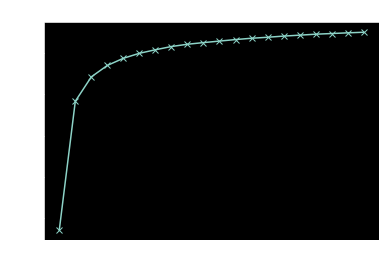

In [66]:
losses, metrics = zip(*history)
plt.plot(metrics, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs no. of epochs')

Text(0.5, 1.0, 'Loss vs no. of epochs')

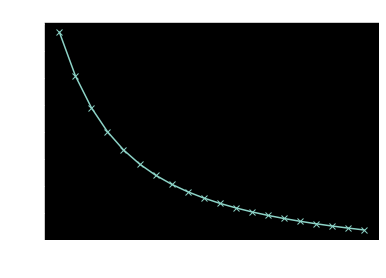

In [67]:
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs no. of epochs')

It's quite clear from the above picture that the model probably won't cross the accuracy threshold of 90% even after training for a very long time. One possible reason for this is that the learning rate might be too high. The model's parameters may be "bouncing" around the optimal set of parameters for the lowest loss. You can try reducing the learning rate and training for a few more epochs to see if it helps.

The more likely reason that **the model just isn't powerful enough**. If you remember our initial hypothesis, we have assumed that the output (in this case the class probabilities) is a **linear function** of the input (pixel intensities), obtained by perfoming a matrix multiplication with the weights matrix and adding the bias. This is a fairly weak assumption, as there may not actually exist a linear relationship between the pixel intensities in an image and the digit it represents. While it works reasonably well for a simple dataset like MNIST (getting us to 85% accuracy), we need more sophisticated models that can capture non-linear relationships between image pixels and labels for complex tasks like recognizing everyday objects, animals etc. 

In [70]:
test_dataset = MNIST(root='data/', train=False, transform=transforms.ToTensor())

Shape: torch.Size([1, 28, 28])
Label: 7


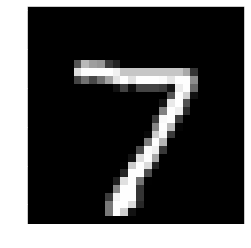

In [71]:
img, label = test_dataset[0]
plt.imshow(img[0, :, :], cmap= 'gray')
print(f"Shape: {img.shape}")
print(f"Label: {label}")

In [72]:
def predict_image(img, model):
    x = img.unsqueeze(0)
    y = model(x)
    max_probs, preds = torch.max(y, dim=1)
    return preds.squeeze().item()

The reason we use `.unsqueeze`, is the model expects a tensor with 4 dimensions, that has a shape of `(batch_size, 1, 28, 28)` but our individual images have the shape of `(1, 28, 28)`. Unsqueeze adds and extra dimension and the specified dimension index. So we use it add the extra batch dimension, so each image becomes a batch of just one image: shape of `(1, 1 28, 28)`

Label: 2, Predicted: 8


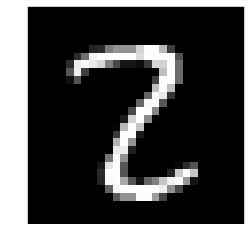

In [77]:
# Change the index to try out different images in the test dataset
index = 1839
img, label = test_dataset[index]
pred = predict_image(img, model)
plt.imshow(img[0, :, :], cmap= 'gray')
print(f"Label: {label}, Predicted: {pred}")

Identifying where our model performs poorly can help us improve the model, by collecting more training data, increasing/decreasing the complexity of the model, and changing the hypeparameters.

As a final step, let's also look at the overall loss and accuracy of the model on the test set.

In [78]:
test_loader = DataLoader(test_dataset, batch_size=200)

test_loss, total, test_acc = evaluate(model, loss_fn, test_loader, metric=accuracy)
print(f"Loss {test_loss}, Accuracy: {test_acc}")

Loss 0.6454753756523133, Accuracy: 0.8617


We expect this to be similar to the accuracy/loss on the validation set. If not, we might need a better validation set that has similar data and distribution as the test set (which often comes from real world data).

## Saving and loading the model

Since we've trained our model for a long time and achieved a resonable accuracy, it would be a good idea to save the weights and bias matrices to disk, so that we can reuse the model later and avoid retraining from scratch. Here's how you can save the model.

In [79]:
torch.save(model.state_dict(), 'mnist-logistic-01.pth')

The `.state_dict` method returns an `OrderedDict` containing all the weights and bias matrices mapped to the right attributes of the model.

In [81]:
model.state_dict()

OrderedDict([('linear.weight',
              tensor([[-0.0050, -0.0296, -0.0329,  ..., -0.0208, -0.0051,  0.0263],
                      [ 0.0346, -0.0085,  0.0224,  ...,  0.0037, -0.0334, -0.0022],
                      [-0.0276,  0.0148,  0.0217,  ...,  0.0071,  0.0005,  0.0208],
                      ...,
                      [-0.0116,  0.0137,  0.0274,  ..., -0.0112, -0.0124,  0.0155],
                      [-0.0009, -0.0052,  0.0244,  ...,  0.0106, -0.0280,  0.0062],
                      [ 0.0113, -0.0020, -0.0154,  ...,  0.0117, -0.0205, -0.0007]])),
             ('linear.bias',
              tensor([-0.0621,  0.0943, -0.0270, -0.0459,  0.0115,  0.0052, -0.0411,  0.0293,
                      -0.0845,  0.0035]))])

To load the model weights, we can instante a new object of the class `MnistModel`, and use the `.load_state_dict` method.

In [82]:
model2 = MnistModel()

In [85]:
model2.load_state_dict(torch.load('mnist-logistic-01.pth'))
model.state_dict()

OrderedDict([('linear.weight',
              tensor([[-0.0050, -0.0296, -0.0329,  ..., -0.0208, -0.0051,  0.0263],
                      [ 0.0346, -0.0085,  0.0224,  ...,  0.0037, -0.0334, -0.0022],
                      [-0.0276,  0.0148,  0.0217,  ...,  0.0071,  0.0005,  0.0208],
                      ...,
                      [-0.0116,  0.0137,  0.0274,  ..., -0.0112, -0.0124,  0.0155],
                      [-0.0009, -0.0052,  0.0244,  ...,  0.0106, -0.0280,  0.0062],
                      [ 0.0113, -0.0020, -0.0154,  ...,  0.0117, -0.0205, -0.0007]])),
             ('linear.bias',
              tensor([-0.0621,  0.0943, -0.0270, -0.0459,  0.0115,  0.0052, -0.0411,  0.0293,
                      -0.0845,  0.0035]))])

In [84]:
evaluate(model, loss_fn, test_loader, metric=accuracy)

(0.6454753756523133, 10000, 0.8617)

In [86]:
test_loss, total, test_acc = evaluate(model2, loss_fn, test_loader, metric=accuracy)
print(f"Loss {test_loss}, Accuracy: {test_acc}")

Loss 0.6454753756523133, Accuracy: 0.8617
